In [3]:
import GEOparse
import pandas as pd
import numpy as np
from scipy import stats
import gseapy as gp
from genelib.data import log2_transform, create_consensus_table
from genelib.plots import volcano_plot, plot_lc_sensitivity, plot_enrichment_results

## Download the Dataset 
 * GSE6613 - Parkinson's disease
 

In [2]:
gse = GEOparse.get_GEO(geo="GSE6613", destdir="data/") # dataset
gpl = GEOparse.get_GEO(geo="GPL96", destdir="data/") # platform table
data = gse.pivot_samples('VALUE')
metadata = gse.phenotype_data

14-Jan-2026 11:29:37 DEBUG utils - Directory data/ already exists. Skipping.
14-Jan-2026 11:29:37 INFO GEOparse - File already exist: using local version.
14-Jan-2026 11:29:37 INFO GEOparse - Parsing data/GSE6613_family.soft.gz: 
14-Jan-2026 11:29:37 DEBUG GEOparse - DATABASE: GeoMiame
14-Jan-2026 11:29:37 DEBUG GEOparse - SERIES: GSE6613
14-Jan-2026 11:29:37 DEBUG GEOparse - PLATFORM: GPL96
14-Jan-2026 11:29:37 DEBUG GEOparse - SAMPLE: GSM153404
14-Jan-2026 11:29:37 DEBUG GEOparse - SAMPLE: GSM153405
14-Jan-2026 11:29:37 DEBUG GEOparse - SAMPLE: GSM153406
14-Jan-2026 11:29:37 DEBUG GEOparse - SAMPLE: GSM153407
14-Jan-2026 11:29:37 DEBUG GEOparse - SAMPLE: GSM153408
14-Jan-2026 11:29:37 DEBUG GEOparse - SAMPLE: GSM153409
14-Jan-2026 11:29:37 DEBUG GEOparse - SAMPLE: GSM153410
14-Jan-2026 11:29:37 DEBUG GEOparse - SAMPLE: GSM153411
14-Jan-2026 11:29:37 DEBUG GEOparse - SAMPLE: GSM153412
14-Jan-2026 11:29:37 DEBUG GEOparse - SAMPLE: GSM153413
14-Jan-2026 11:29:37 DEBUG GEOparse - SAMPLE:

## Preprocessing 

In [3]:
data = log2_transform(data)

In [4]:
# Inspect metadata
print(metadata['title'])

GSM153404             Parkinson's disease sample x001
GSM153405                 healthy control sample x004
GSM153406                 healthy control sample x005
GSM153407             Parkinson's disease sample x006
GSM153408             Parkinson's disease sample x007
                               ...                   
GSM153504    neurological disease control sample x203
GSM153505             Parkinson's disease sample x204
GSM153506             Parkinson's disease sample x205
GSM153507    neurological disease control sample x208
GSM153508                 healthy control sample x302
Name: title, Length: 105, dtype: object


### Label the dataset : Disease vs Control

In [ ]:
# Label Parkinson's vs control
labels = []

for i in metadata.index:
    if "Parkinson's disease" in metadata.loc[i, 'title']:
        labels.append(1) # Disease
    else:
        labels.append(0) # Control

metadata['target'] = labels
print(f"Class distribution: \n{metadata['target'].value_counts()}")


Class distribution: 
target
0    55
1    50
Name: count, dtype: int64


### Probe to Gene Mapping 

In [6]:
# Get the annotation table and create the map of probe->gene
annot = gpl.table
# remove variant gene name (if any). Usually seprated by '///'
annot['Gene Symbol'] = annot['Gene Symbol'].astype(str).str.split('///').str[0].str.strip()
probe_to_gene = dict(zip(annot['ID'], annot['Gene Symbol']))

In [7]:
# apply mapping
data.index = data.index.map(probe_to_gene)

In [8]:
# Cleanup : Drop missing names and average duplicates
data = data.dropna()
data = data.groupby(data.index).mean()
print(f"\nFinal Features : {data.shape[0]} genes")


Final Features : 13238 genes


In [9]:
# Split dataset based on the labels (PD vs Control)
pd_patients = data.loc[:, metadata['target'] == 1]
healthy = data.loc[:, metadata['target'] == 0]
print(f"Parkinson's Disease Samples: {pd_patients.shape[1]}\
      \nControl Samples: {healthy.shape[1]}")

Parkinson's Disease Samples: 50      
Control Samples: 55


In [10]:
def run_ttest(data):
    results = []
    for gene in data.index:
        t_stat, p_val = stats.ttest_ind(pd_patients.loc[gene], healthy.loc[gene])
        log_fc = pd_patients.loc[gene].mean() - healthy.loc[gene].mean()
        results.append({'Gene': gene,'p_value': p_val, 'log_fc':log_fc})
    df_res = pd.DataFrame(results).set_index('Gene')
    df_res['significant'] = (df_res['p_value'] < 0.01) & (df_res['log_fc'].abs() > 0.25)
    return df_res

In [11]:
df_ttest = run_ttest(data)

In [12]:
df_ttest.head(10)

,p_value,log_fc,significant
Gene,,,
A1CF,0.556055,-0.052985,False
A2M,0.253946,0.284657,False
A4GALT,0.059101,-0.279465,False
A4GNT,0.212118,0.238271,False
AAAS,0.676175,-0.084578,False
AACS,0.686280,-0.072132,False
AADAC,0.284251,-0.180755,False
AAGAB,0.057501,0.203189,False
AAK1,0.233871,0.097368,False


### Visualize Welch's T-test

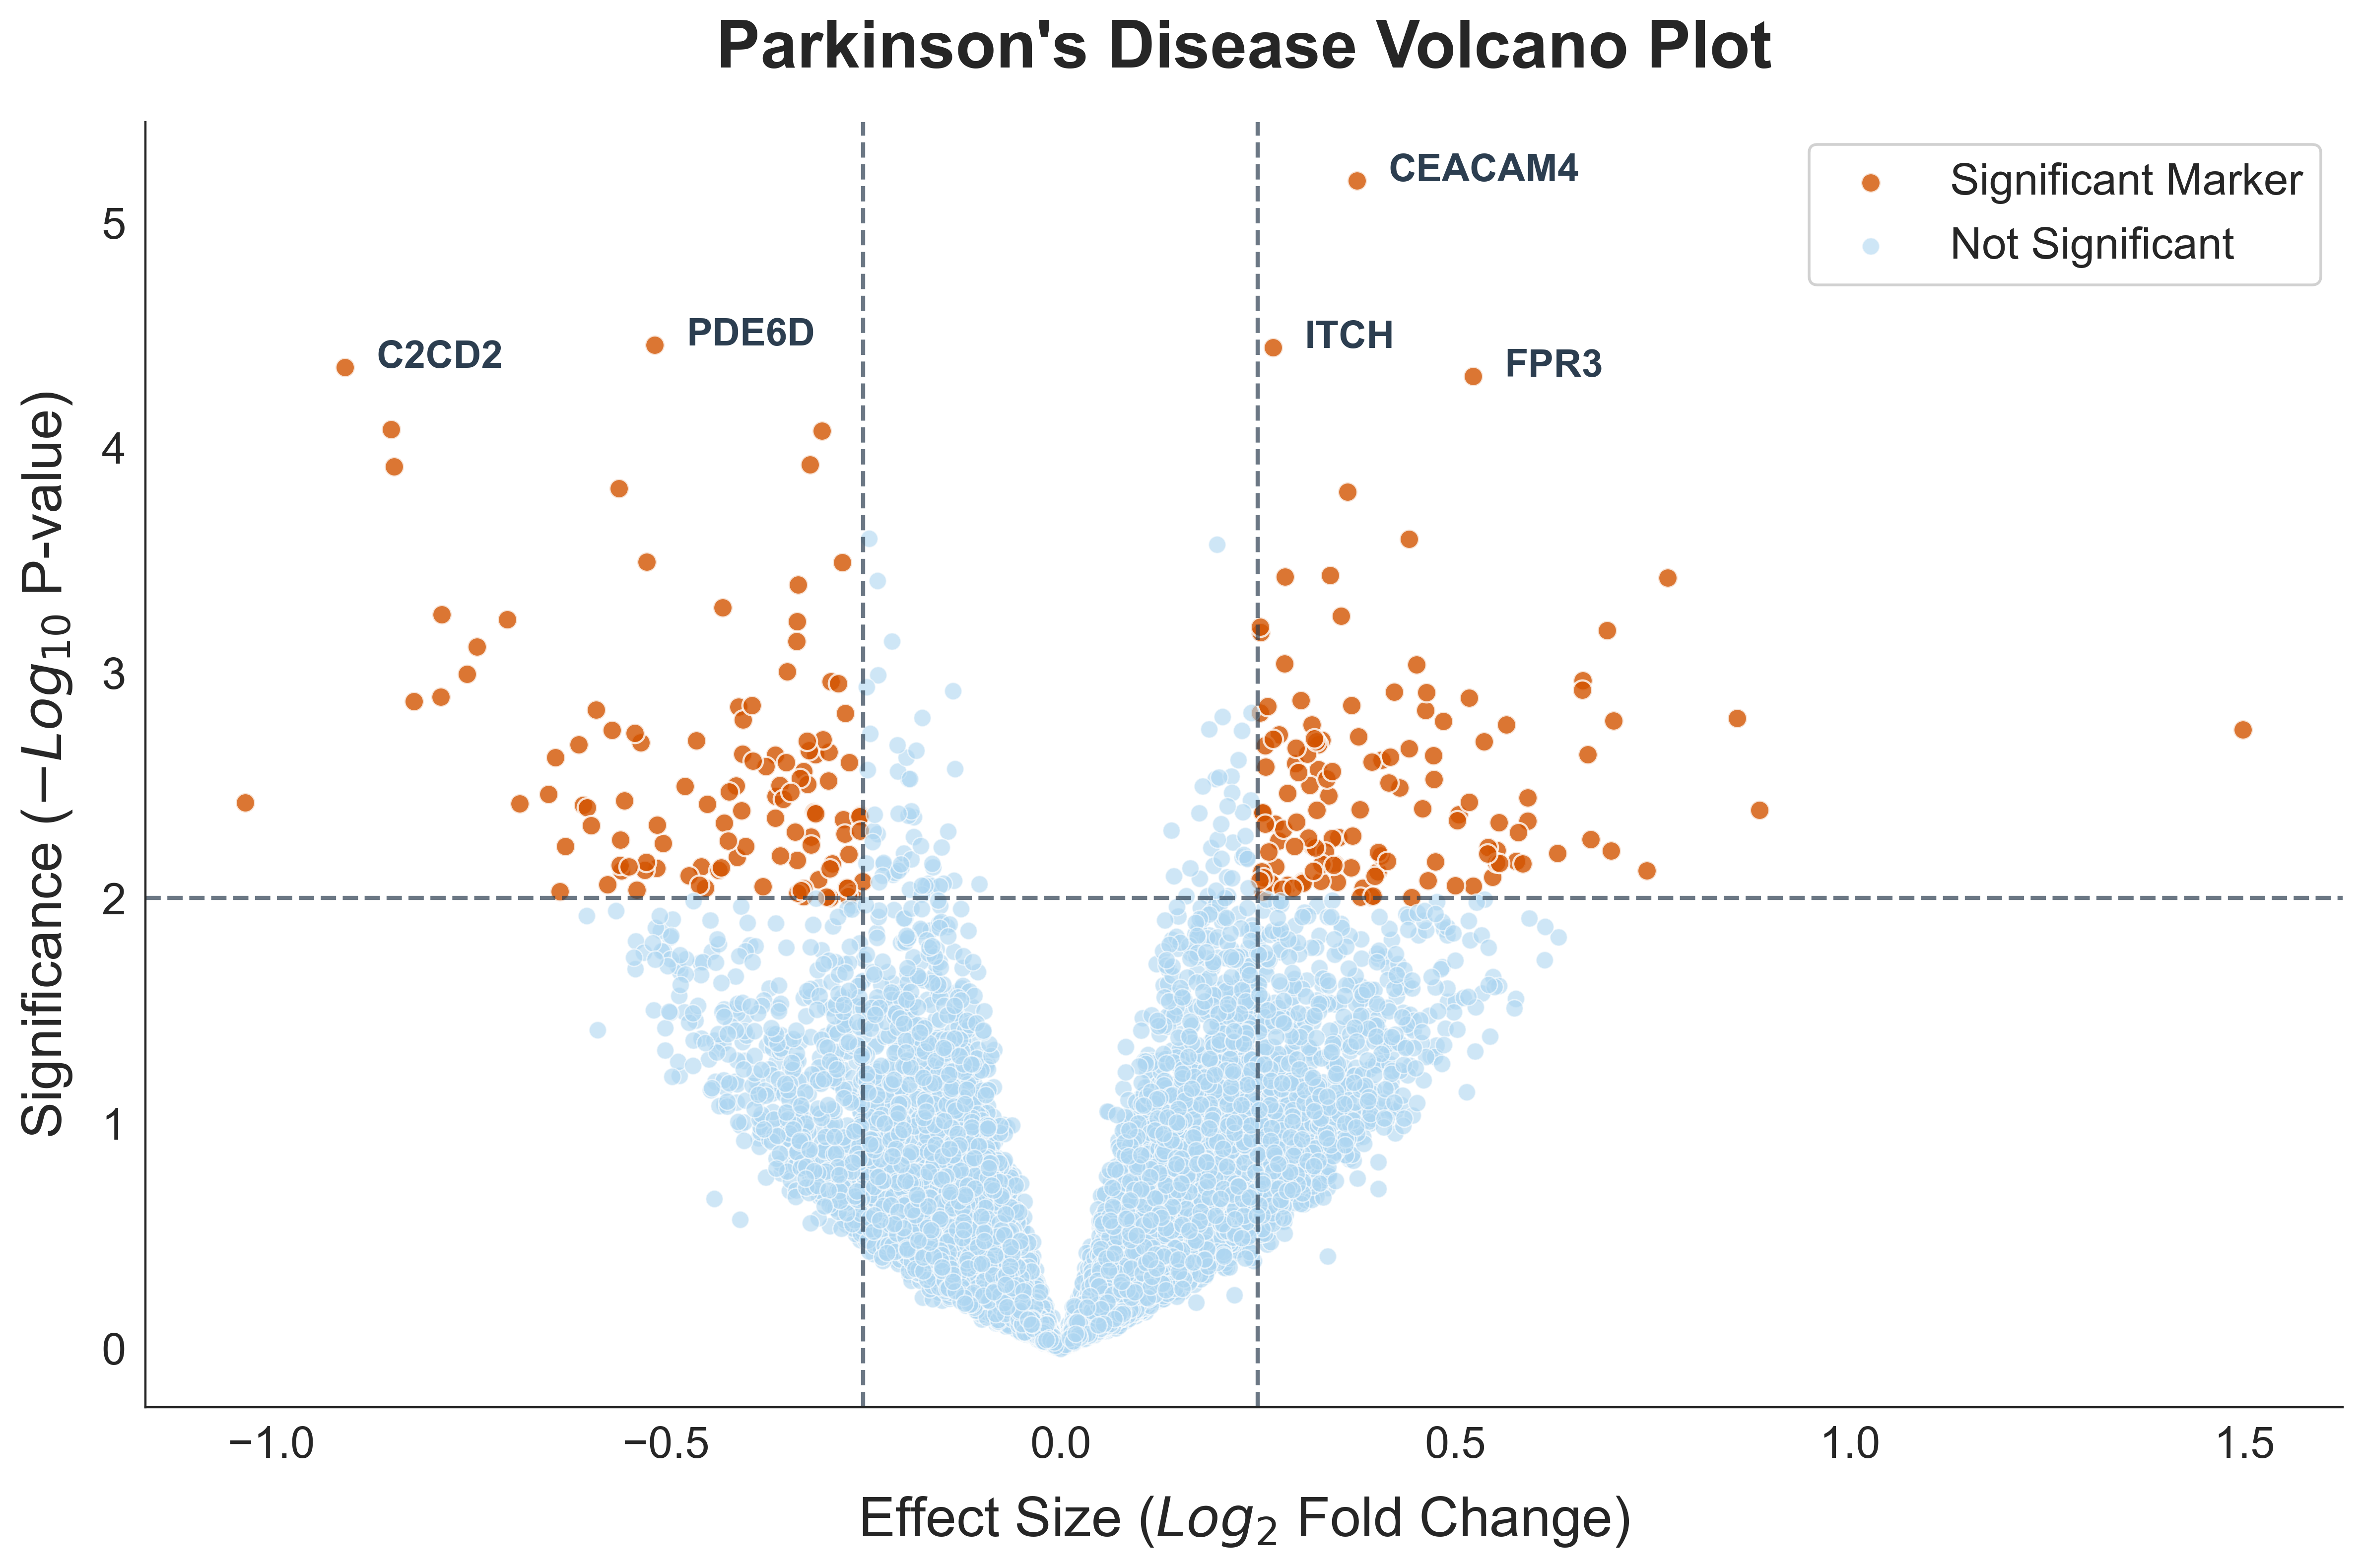

Plot saved as: results/Parkinson's Disease Volcano Plot.svg


True

In [13]:
volcano_plot(df_ttest)

# Machine Learning 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [15]:
# Lets use the biomarkers found in the t-test
selected_genes = df_ttest[df_ttest['significant'] == True].index
X = data.loc[selected_genes].T
y = metadata['target']
print(f"Input Shape: {X.shape}")
print(f"Target Shape: {y.shape}")

Input Shape: (105, 248)
Target Shape: (105,)


### Learning Curve and Sensitivity Analysis

True

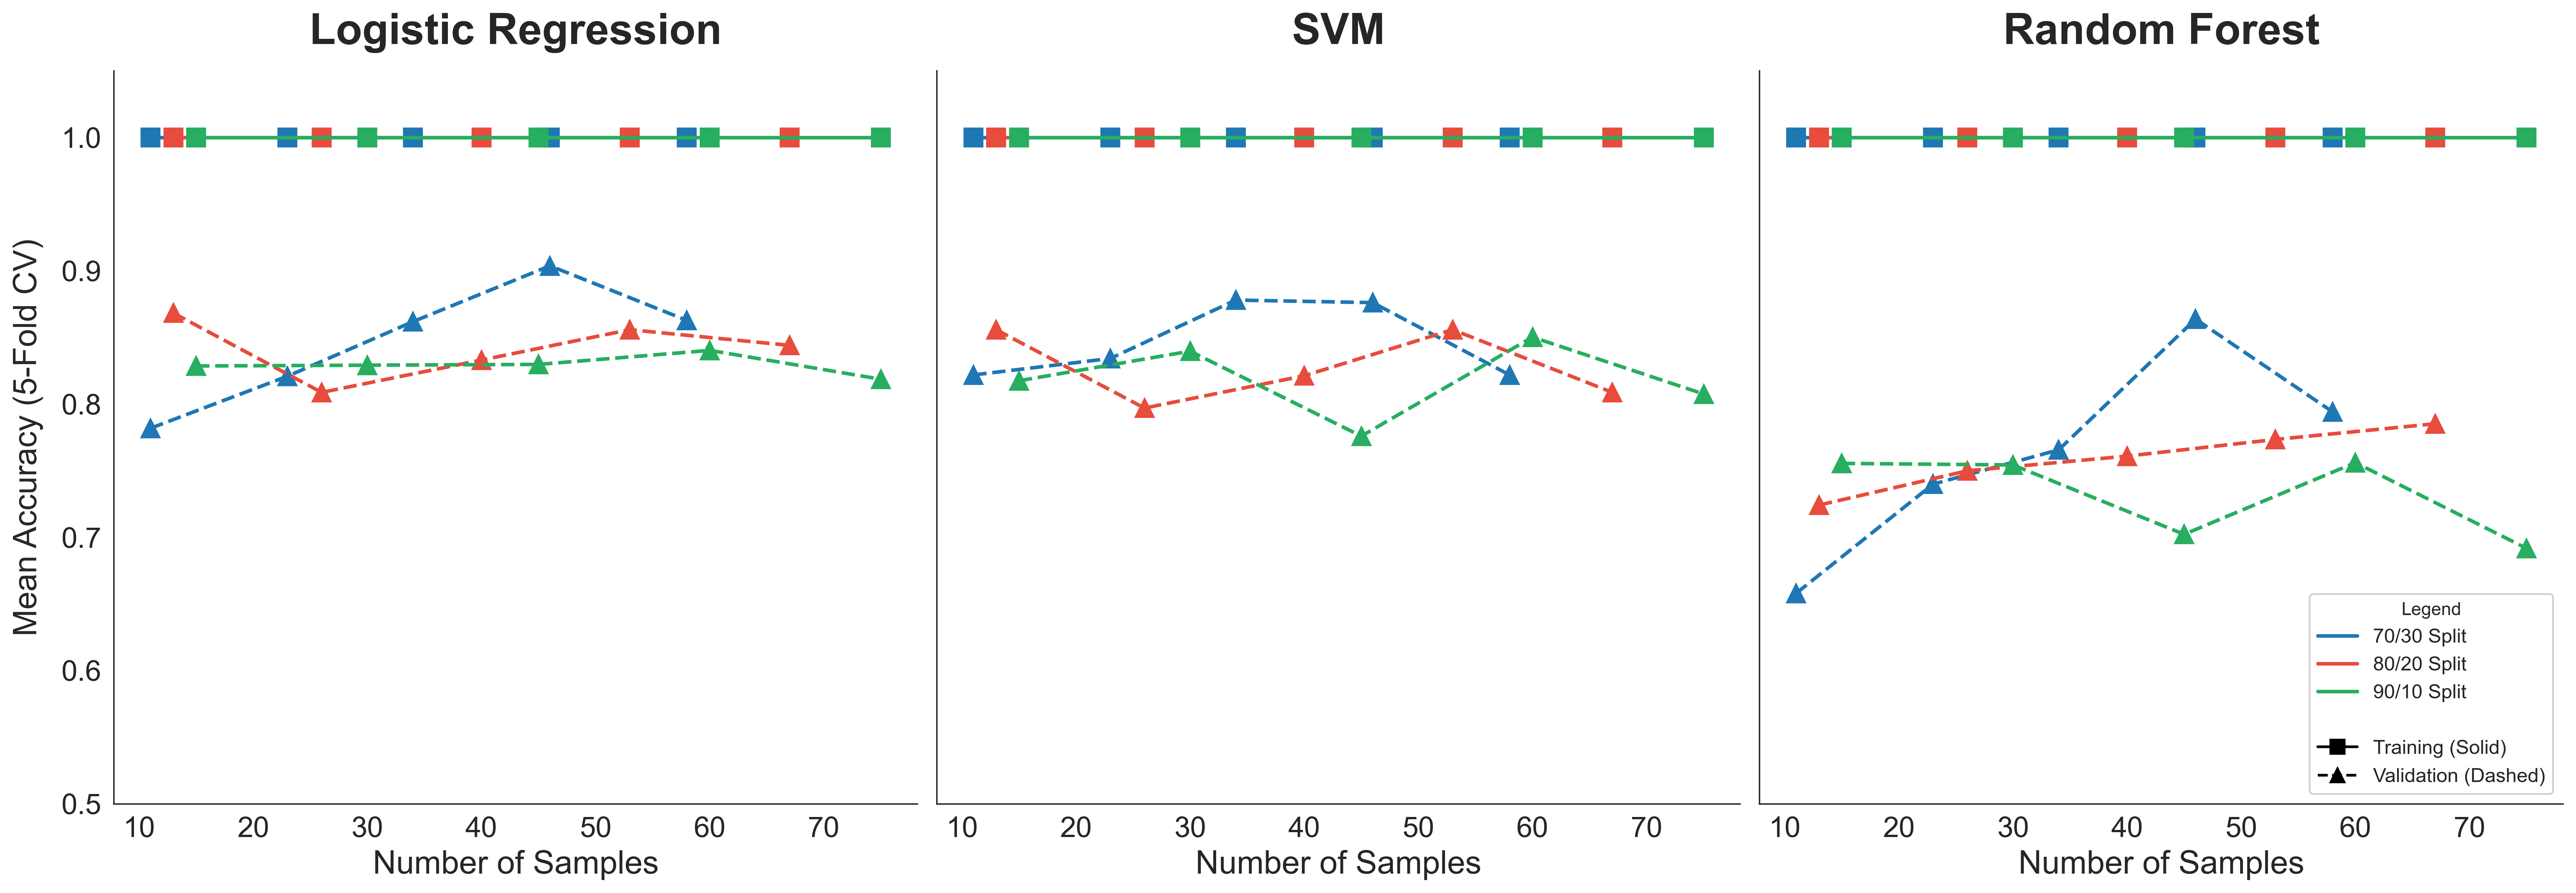

In [16]:
plot_lc_sensitivity(X=X, y=y)

### Train-Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)
print(len(X_train),len(X_test))

94 11


### SVM 

In [26]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print(f"SVM Accuracy: {svm_acc:.2%}")
print("\n--- SVM Report ---")
print(classification_report(y_test, svm_pred))

SVM Accuracy: 90.91%

--- SVM Report ---
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.83      0.91         6

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.91        11
weighted avg       0.92      0.91      0.91        11



### Logistic Regression

In [27]:
log_model = LogisticRegression(solver='liblinear', random_state=42)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
log_acc = accuracy_score(y_test, log_pred)
print(f"Logistic Regression Accuracy: {log_acc:.2%}")
print("\n--- Logistic Regression Report ---")
print(classification_report(y_test, log_pred))

Logistic Regression Accuracy: 90.91%

--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.83      0.91         6

    accuracy                           0.91        11
   macro avg       0.92      0.92      0.91        11
weighted avg       0.92      0.91      0.91        11



### Random Forest Classifier

In [31]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {rf_acc:.2%}")
print("\nClassification Report:\n", classification_report(y_test, rf_pred))

Random Forest Accuracy: 81.82%

Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      0.67      0.80         6

    accuracy                           0.82        11
   macro avg       0.86      0.83      0.82        11
weighted avg       0.87      0.82      0.82        11



### Top Genes from Logistic Regression

In [21]:
# get weights of each gene
coeffs = pd.DataFrame({'Gene': selected_genes, 'weight': log_model.coef_[0]})
# Sort by abs weight
coeffs['abs_weight'] = coeffs['weight'].abs()
top_genes_log = coeffs.sort_values('abs_weight', ascending=False).head(10)
print("\nTop 10 Genes used by logistic Regression: \n")
print(top_genes_log[['Gene', 'weight']])


Top 10 Genes used by logistic Regression: 

        Gene    weight
239   ZBTB33 -0.456506
181   RPL39L -0.440374
247  ZNF780A  0.426067
217    TXLNA -0.409677
75   ERVK3-2  0.397487
0      ABCD2 -0.371150
102    IFI27 -0.366356
142     NME7 -0.353889
76      ETV2  0.348158
115    KLKB1  0.347447


In [40]:
consensus_df = create_consensus_table(df_ttest, log_model, svm_model,rf_model,
                                      selected_genes=selected_genes,
                                      top_n=10)

print(consensus_df)

      Gene   p_value  LogReg_Weight  SVM_Weight    RF_Imp  RF_Rank  \
0  CEACAM4  0.000007       0.083924    0.023652  0.020376      1.0   
1    PDE6D  0.000035      -0.114979   -0.025902  0.011383     12.0   
2     ITCH  0.000036       0.023865   -0.000018  0.013990      5.0   
3    C2CD2  0.000044      -0.028492   -0.001431  0.006993     41.0   
4     FPR3  0.000048       0.134529    0.043152  0.011715     11.0   
5    IFI27  0.000083      -0.366356   -0.089340  0.015935      3.0   
6      ADO  0.000084      -0.126735   -0.044488  0.005958     54.0   
7     GSAP  0.000119      -0.055189   -0.016818  0.003783    103.0   
8    TXLNA  0.000121      -0.409677   -0.112440  0.004378     88.0   
9     LSM7  0.000152      -0.043605   -0.010165  0.002227    163.0   

   Strong Consensus  
0              True  
1             False  
2              True  
3             False  
4             False  
5              True  
6             False  
7             False  
8             False  
9        

## BioInformatics

## Functional Enrichment Analysis (FEA)

FEA Identifies biological functions, pathways, or processes that are statistically over-represented (enriched in a list of genes)

In [22]:
top_gene_list = df_ttest.sort_values('p_value').head(100).index.tolist()

No pathways met the strict significance threshold (Adj P < 0.05).
Showing top 5 raw results instead:
                                                Term Overlap   P-value
0                               Steroid biosynthesis    2/20  0.004434
1                              Propanoate metabolism    2/34  0.012512
2  Endocrine and other factor-regulated calcium r...    2/53  0.028910
3                                 Mineral absorption    2/60  0.036310
4                                        Spliceosome   3/150  0.039464


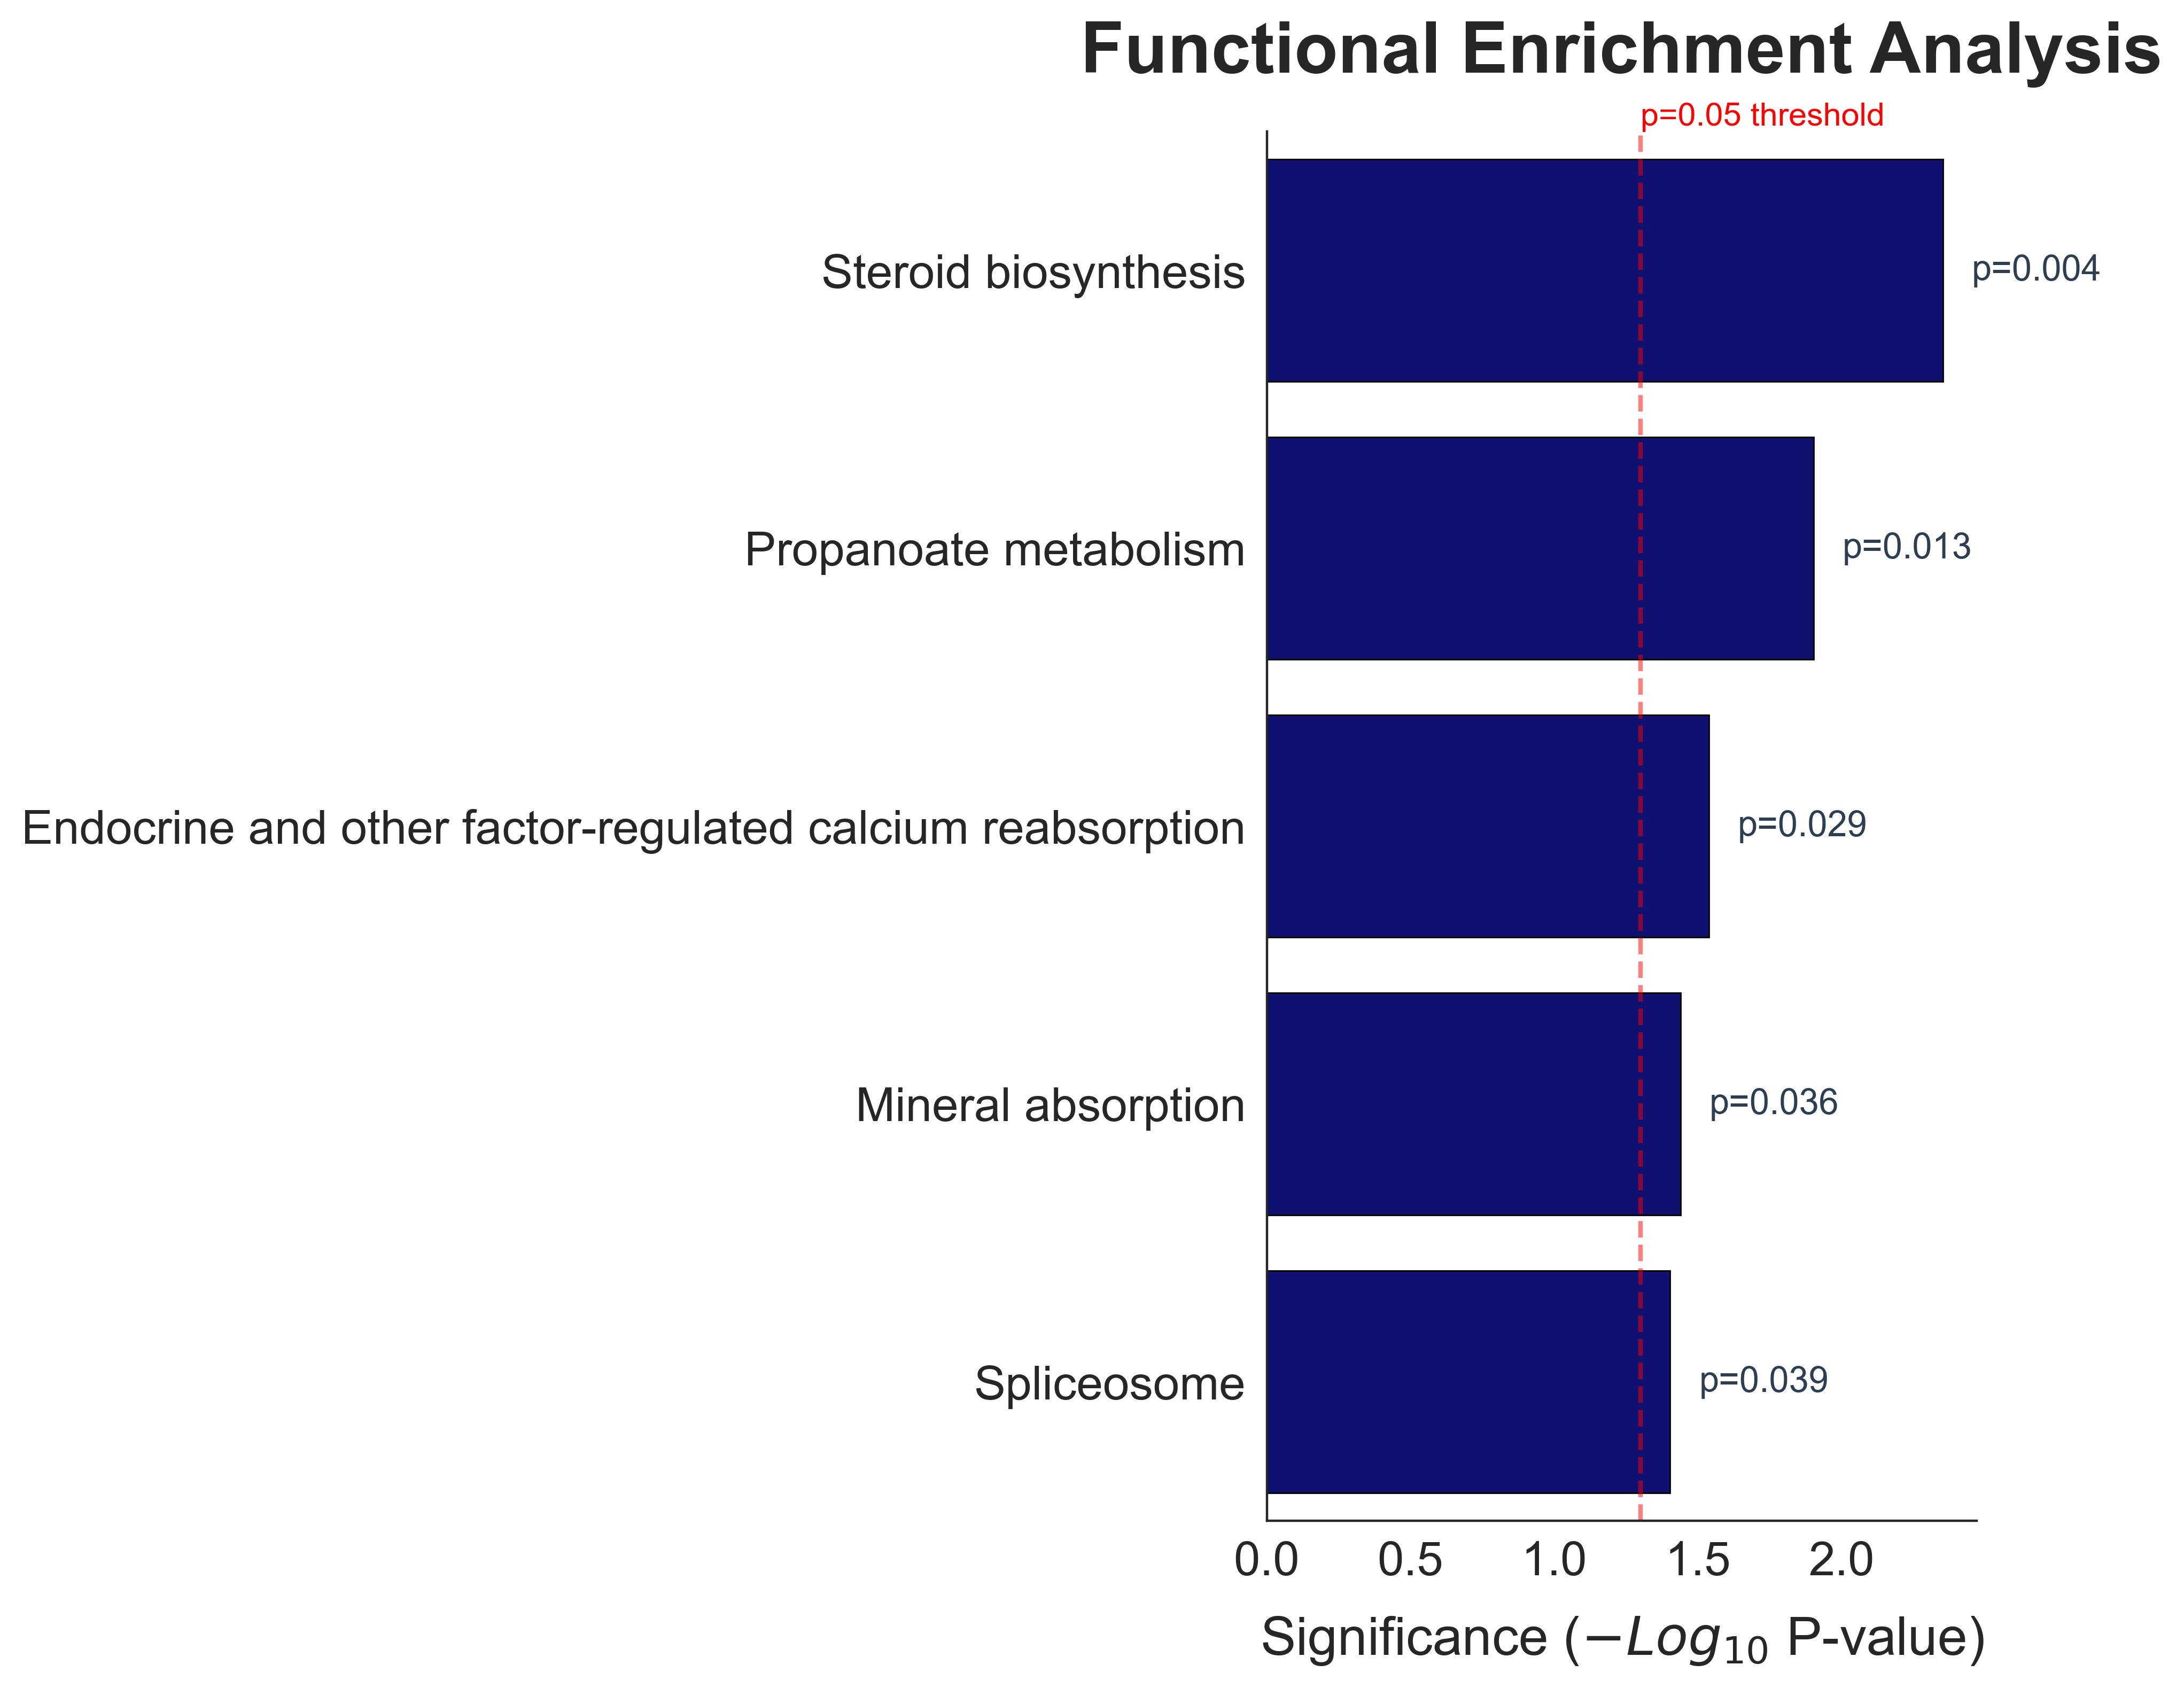

Plot saved as: results/enrichment_barplot.svg


In [23]:
# Run FEA
# Two libraries:
#   - 'GO_Biological_Process_2023' --> bio tasks associated with these genes?
#   - 'KEGG_2021_Human' --> Pathways these genes involved in?

gene_sets = ['GO_Biological_Process_2023', 'KEGG_2021_Human']

try:
    enr = gp.enrichr(gene_list=top_gene_list, gene_sets=gene_sets,
                    organism='Human', outdir=None)
    results = enr.results

    # Fiter for significant terms (Adjusted P-value < 0.05)
    sig_results = results[results['Adjusted P-value']<0.05]

    if sig_results.empty:
        print("No pathways met the strict significance threshold (Adj P < 0.05).")
        print("Showing top 5 raw results instead:")
        print(results[['Term', 'Overlap', 'P-value']].head(5))
    else:
        print(f"Found {len(sig_results)} significant pathways")
        print(sig_results[['Term', 'Overlap', 'Adjusted P-value']].head(10))

    plot_enrichment_results(results)

except Exception as e:
    print(f"Enrichment failed: {e}")
    print("Tip: Make sure you have an internet connection (gseapy queries online databases).")


